In [2]:
# import libraries
!pip install gseapy
import matplotlib.pyplot as plt
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
import gseapy as gp
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.9/552.9 kB 3.6 MB/s eta 0:00:00


In [3]:
# get data and decompress file
! wget -O GSE95077_Normalized_Count_Matrix_JJN3_Amiloride_and_CTRL.txt.gz 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE95077&format=file&file=GSE95077%5FNormalized%5FCount%5FMatrix%5FJJN3%5FAmiloride%5Fand%5FCTRL%2Etxt%2Egz'

! gunzip GSE95077_Normalized_Count_Matrix_JJN3_Amiloride_and_CTRL.txt

--2024-07-23 12:47:29--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE95077&format=file&file=GSE95077%5FNormalized%5FCount%5FMatrix%5FJJN3%5FAmiloride%5Fand%5FCTRL%2Etxt%2Egz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 342237 (334K) [application/octet-stream]
Saving to: ‘GSE95077_Normalized_Count_Matrix_JJN3_Amiloride_and_CTRL.txt.gz’

GSE95077_Normalized 100%[===================>] 334.22K  --.-KB/s    in 0.1s    

2024-07-23 12:47:29 (2.49 MB/s) - ‘GSE95077_Normalized_Count_Matrix_JJN3_Amiloride_and_CTRL.txt.gz’ saved [342237/342237]



In [4]:
# define the file path, load the data into a DataFrame, and view the first 5 rows
path = 'GSE95077_Normalized_Count_Matrix_JJN3_Amiloride_and_CTRL.txt'
data = pd.read_csv(path, sep='\t', index_col=0)
data.head()

,JJ_AMIL_141050_INTER-Str_counts,JJ_AMIL_141056_INTER-Str_counts,JJ_AMIL_141062_INTER-Str_counts,JJ_CTRL_141048_INTER-Str_counts,JJ_CTRL_141054_INTER-Str_counts,JJ_CTRL_141060_INTER-Str_counts
ENSG00000000419,1520.00,2420.00,2820.00,1880.00,1610.00,1760.00
ENSG00000000457,675.00,765.00,772.00,777.00,744.00,795.00
ENSG00000000460,1110.00,1060.00,855.00,999.00,906.00,791.00
ENSG00000000938,3.96,2.41,3.68,1.13,3.43,1.28
ENSG00000000971,3000.00,2570.00,2810.00,2820.00,2450.00,2560.00


In [5]:
# check for missing values and get summary statistics
print(data.isnull().sum())
print(data.describe())

JJ_AMIL_141050_INTER-Str_counts    0
JJ_AMIL_141056_INTER-Str_counts    0
JJ_AMIL_141062_INTER-Str_counts    0
JJ_CTRL_141048_INTER-Str_counts    0
JJ_CTRL_141054_INTER-Str_counts    0
JJ_CTRL_141060_INTER-Str_counts    0
dtype: int64
       JJ_AMIL_141050_INTER-Str_counts  JJ_AMIL_141056_INTER-Str_counts  \
count                     23044.000000                     23044.000000   
mean                       1356.780368                      1353.518434   
std                        4615.739107                      4510.666648   
min                           0.000000                         0.000000   
25%                           2.640000                         3.210000   
50%                          96.300000                        94.700000   
75%                        1160.000000                      1180.000000   
max                      182000.000000                    166000.000000   

       JJ_AMIL_141062_INTER-Str_counts  JJ_CTRL_141048_INTER-Str_counts  \
count         

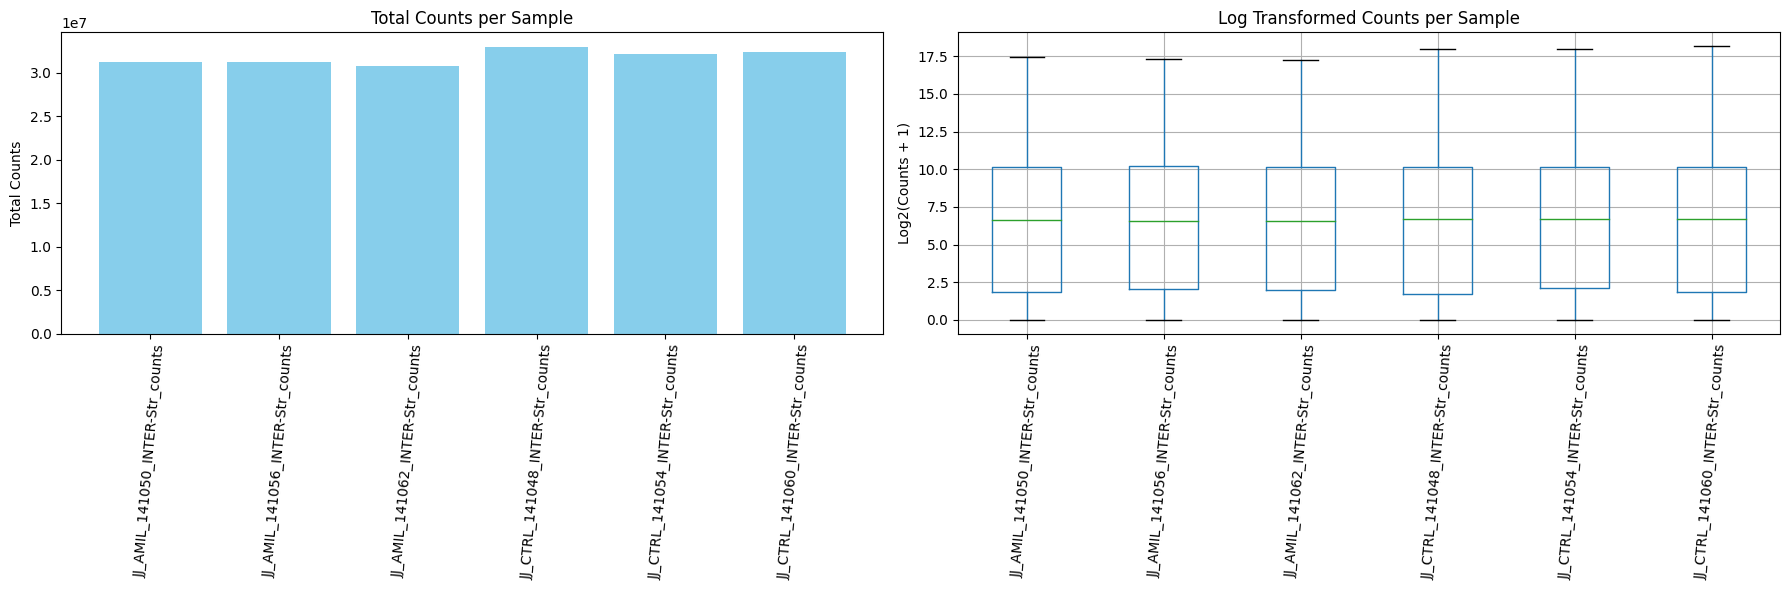

In [11]:
# calcualte total counts per sample and log transform counts
total_counts = data.sum(axis=0)
log_counts = data.apply(lambda x: np.log2(x + 1))

# create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# subplot 1: total counts per sample
axes[0].bar(data.columns, total_counts, color='skyblue')
axes[0].set_ylabel('Total Counts')
axes[0].set_title('Total Counts per Sample')
axes[0].tick_params(axis='x', rotation=85)

# subplot 2: log transformed counts per sample
log_counts.boxplot(ax=axes[1])
axes[1].set_ylabel('Log2(Counts + 1)')
axes[1].set_title('Log Transformed Counts per Sample')
axes[1].tick_params(axis='x', rotation=85)

plt.tight_layout()
plt.show()

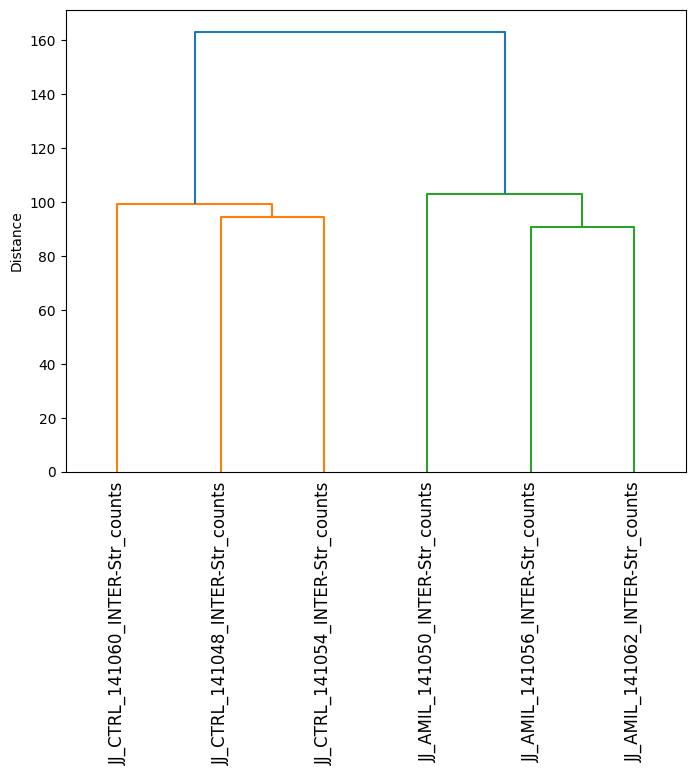

In [12]:
h_clustering = linkage(log_counts.T, 'ward')
plt.figure(figsize=(8, 6))
dendrogram(h_clustering, labels=data.columns)
plt.xticks(rotation=90)
plt.ylabel('Distance')
plt.show()

In [6]:
def filter_genes(data, min_cpm=1, min_samples=3):
    cpm = data.apply(lambda x: (x / x.sum()) * 1e6)
    mask = (cpm > min_cpm).sum(axis=1) >= min_samples #
    return data[mask]

data = filter_genes(data)

In [91]:
results = []
for gene in data.index:
    control = data.loc[gene, ['JJ_AMIL_141050_INTER-Str_counts', 'JJ_AMIL_141056_INTER-Str_counts', 'JJ_AMIL_141062_INTER-Str_counts']]
    treated = data.loc[gene, ['JJ_CTRL_141048_INTER-Str_counts', 'JJ_CTRL_141054_INTER-Str_counts', 'JJ_CTRL_141060_INTER-Str_counts']]
    mean_control = np.mean(control)
    mean_treated = np.mean(treated)
    log2fc = np.log2((mean_treated + 1) / (mean_control + 1))  # Adding 1 to avoid log of 0
    t_stat, p_val = ttest_ind(control, treated)
    results.append({'gene': gene, 'log2fc': log2fc, 't_stat': t_stat, 'p_val': p_val})

results_df = pd.DataFrame(results)

results_df['p_adj'] = multipletests(results_df['p_val'], method='fdr_bh')[1]

results_df['abs_log2fc'] = results_df['log2fc'].abs()

deg = results_df[(results_df['p_adj'] < 0.01) & (results_df['abs_log2fc'] > 1)]

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment 

In [83]:
top_genes = deg.sort_values(by=['log2fc', 'p_adj'], ascending=[False, True])
top_25_genes = top_genes.head(25)
print(top_25_genes[['gene', 'log2fc', 'p_adj']])

                  gene    log2fc     p_adj
10585  ENSG00000198804  3.310904  0.007075
12123  ENSG00000237973  2.996150  0.008481
1295   ENSG00000088882  2.485047  0.009834
5757   ENSG00000143847  2.355796  0.008878
6145   ENSG00000148600  2.189825  0.008481
11583  ENSG00000228366  2.187151  0.006735
12401  ENSG00000247095  2.131597  0.006806
10709  ENSG00000204252  2.096927  0.006879
11774  ENSG00000231890  2.029460  0.009575
8798   ENSG00000174871  1.983289  0.005708
12727  ENSG00000257337  1.939167  0.002610
12284  ENSG00000242574  1.923054  0.007075
2060   ENSG00000104213  1.920566  0.008456
10617  ENSG00000198886  1.828245  0.009740
8394   ENSG00000171084  1.820087  0.006806
12434  ENSG00000248329  1.777131  0.009883
110    ENSG00000006704  1.710256  0.009578
11669  ENSG00000230006  1.623009  0.009694
11613  ENSG00000228889  1.613159  0.007034
4621   ENSG00000133454  1.612313  0.008791
11561  ENSG00000228133  1.604213  0.009560
9524   ENSG00000183048  1.593315  0.008573
3039   ENSG

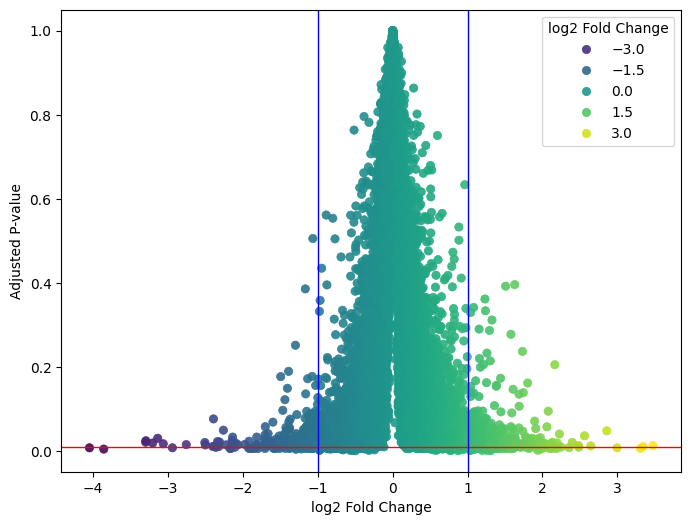

In [105]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x='log2fc', y='p_adj', hue='log2fc', palette='viridis', alpha=0.9, edgecolor=None)
plt.axhline(y=0.01, color='red', linestyle='-', linewidth=1)
plt.axvline(x=1, color='blue', linestyle='-', linewidth=1)
plt.axvline(x=-1, color='blue', linestyle='-', linewidth=1)
plt.xlabel('log2 Fold Change')
plt.ylabel('Adjusted P-value')
plt.legend(title='log2 Fold Change', loc='upper right')
plt.show()



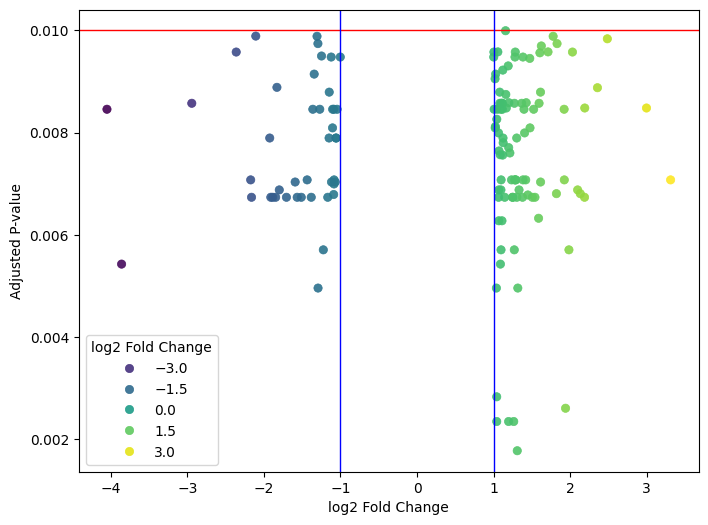

In [104]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=deg, x='log2fc', y='p_adj', hue='log2fc', palette='viridis', alpha=0.9, edgecolor=None)
plt.axhline(y=0.01, color='red', linestyle='-', linewidth=1)
plt.axvline(x=1, color='blue', linestyle='-', linewidth=1)
plt.axvline(x=-1, color='blue', linestyle='-', linewidth=1)
plt.xlabel('log2 Fold Change')
plt.ylabel('Adjusted P-value')
plt.legend(title='log2 Fold Change', loc='lower left')
plt.show()

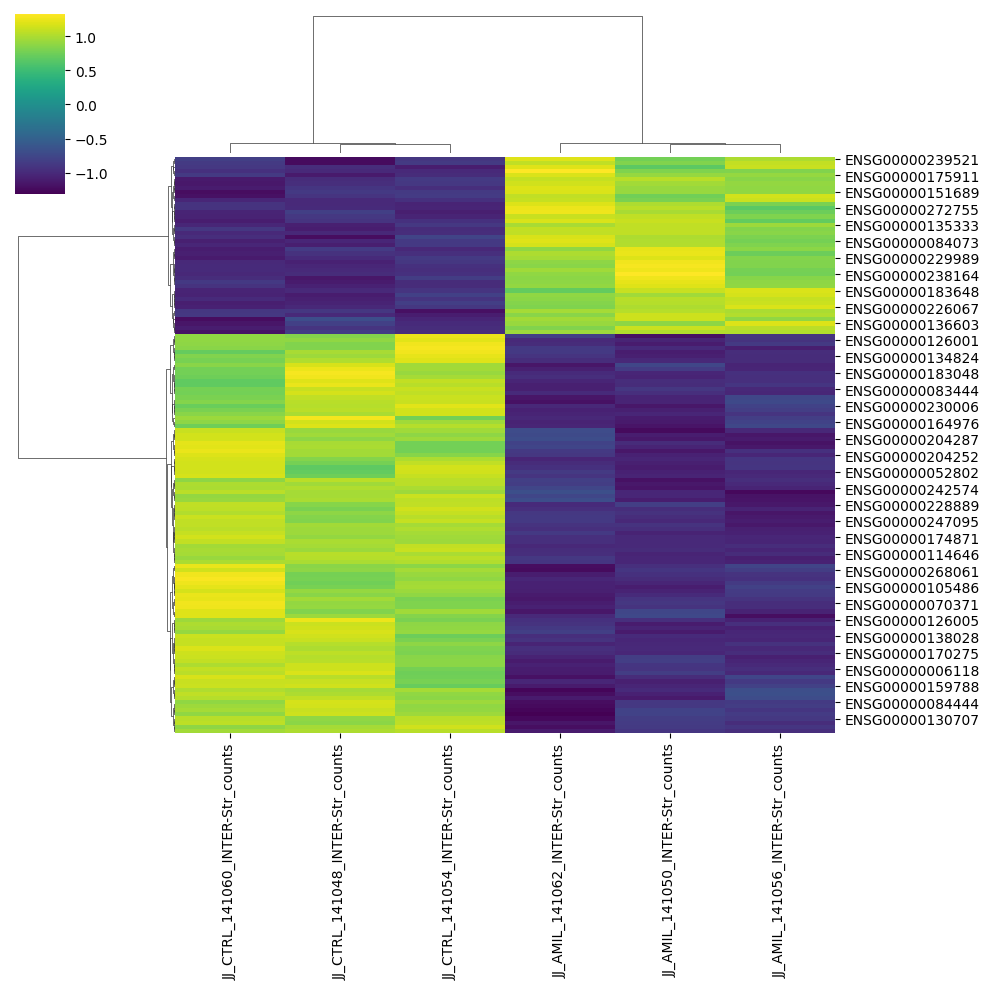

In [136]:
significant_genes = deg['gene'].tolist()
data_sig = data.loc[significant_genes]
scaler = StandardScaler()
data_sig_scaled = pd.DataFrame(scaler.fit_transform(data_sig.T).T, index=data_sig.index, columns=data_sig.columns)
sns.clustermap(data_sig_scaled, method='ward', cmap='viridis', metric='euclidean', figsize=(10, 10), dendrogram_ratio=(0.2, 0.2))
plt.show()

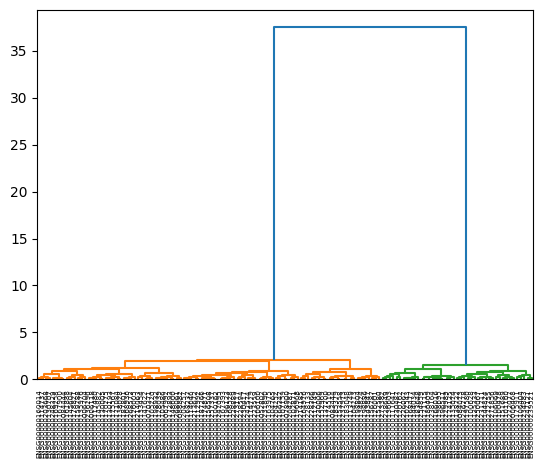

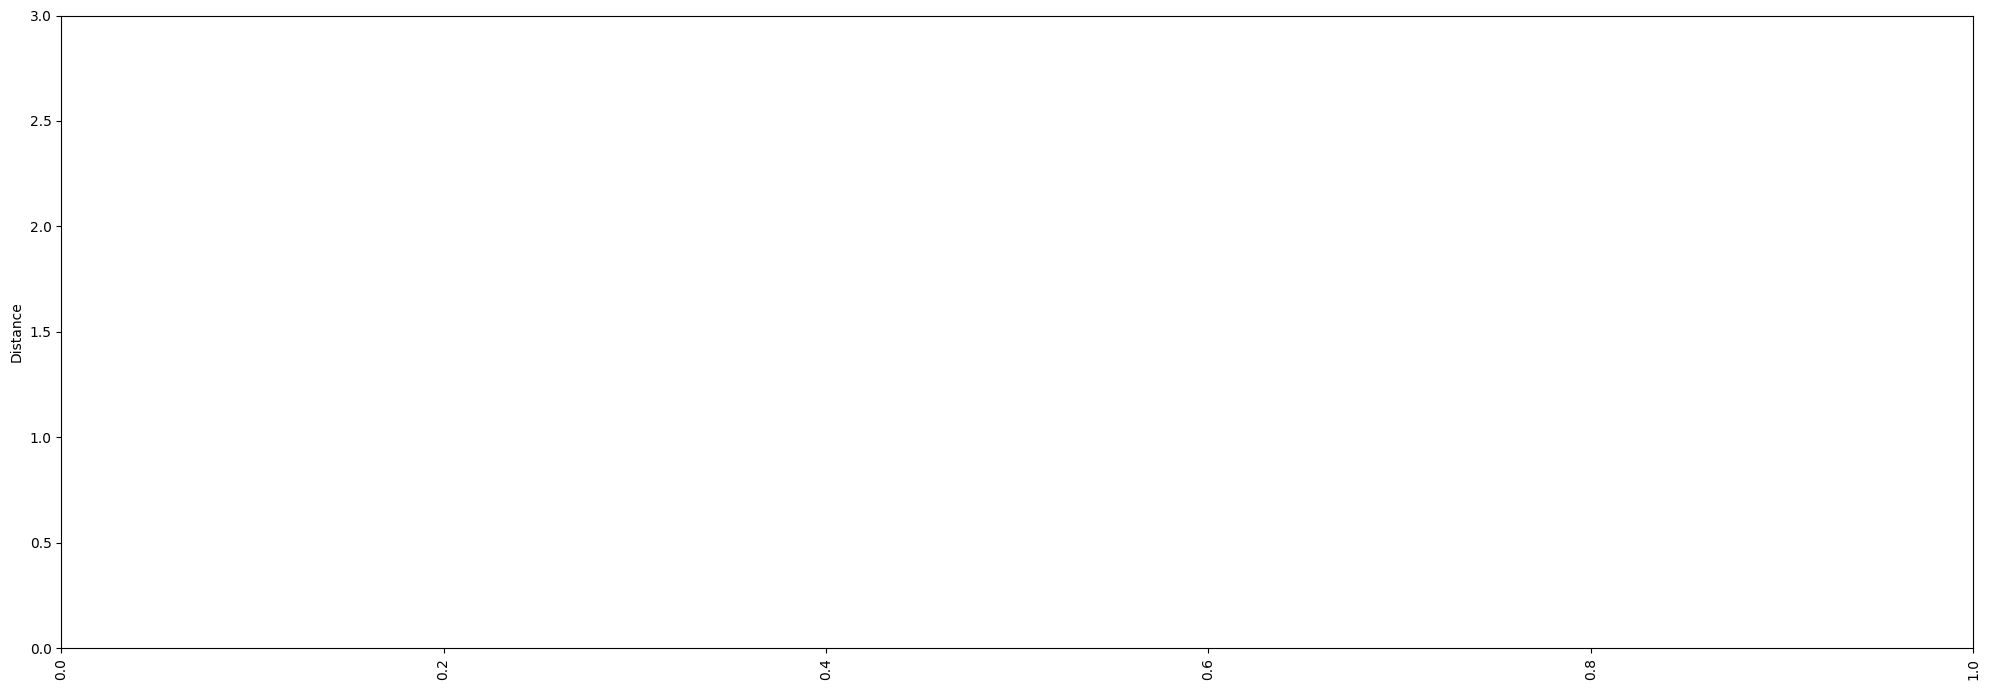

In [147]:
significant_genes = deg['gene'].tolist()
data_sig = data.loc[significant_genes]
scaler = StandardScaler()
data_sig_scaled = pd.DataFrame(scaler.fit_transform(data_sig.T).T, index=data_sig.index, columns=data_sig.columns)
distance_matrix = pdist(data_sig_scaled, metric='euclidean')
linkage_matrix = linkage(distance_matrix, method='ward')
dendrogram(linkage_matrix, labels=data_sig.index, orientation='top', distance_sort='descending')
plt.figure(figsize=(20, 7))
plt.ylabel('Distance')
plt.ylim(0, 3)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
